## Depricated (Used to test)

In [2]:
import cartopy
import numpy as np
import xesmf as xe
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt


import sys
sys.path.append(str(Path.cwd().parents[1]))
from fetch_data import fetch_data_from_copernicus_marine
from utilities import get_region_border


/home/anna/miniconda3/envs/resize-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# fetch from copernicus marine service
date = '2021-07-07'

region_coords = get_region_border("/home/anna/msc_oppgave/fish-forecast/areas.json", "FA_JunNov_download")
depths = [3, 3]

bio_dict_small = {
    "dataset_id": "cmems_mod_arc_bgc_anfc_ecosmo_P1D-m",
    "longitude": [region_coords["SW"]["lon"], region_coords["SE"]["lon"]],
    "latitude": [region_coords["SW"]["lat"], region_coords["NE"]["lat"]],
    "time": [f"{date}T00:00:00", f"{date}T00:00:00"],
    "variables": ["chl", "kd", "model_depth", "no3", "nppv", "o2", "phyc", "po4", "si", "zooc"],
    "depths": depths
}
bio_dict_big = bio_dict_small.copy()
bio_dict_big["dataset_id"] = "cmems_mod_arc_bgc_my_ecosmo_P1D-m"

ds25 = fetch_data_from_copernicus_marine(bio_dict_big)
ds625 = fetch_data_from_copernicus_marine(bio_dict_small)

# save the datasets
ds25_path = f"/home/anna/msc_oppgave/fish-forecast/other/resample_ex/{date}_25.nc"
ds625_path = f"/home/anna/msc_oppgave/fish-forecast/other/resample_ex/{date}_625.nc"
ds25.to_netcdf(ds25_path)
ds625.to_netcdf(ds625_path)

phy_path = f"/home/anna/msc_oppgave/fish-forecast/Data/mac_winter_areas/phy/{date}.nc"
ds_phy = xr.open_dataset(phy_path)



INFO - 2025-07-20T00:32:05Z - Selected dataset version: "202105"
INFO - 2025-07-20T00:32:05Z - Selected dataset part: "default"
INFO - 2025-07-20T00:32:10Z - Selected dataset version: "202105"
INFO - 2025-07-20T00:32:10Z - Selected dataset part: "default"


In [4]:
# find max and min lat/lon for each dataset
def get_lat_lon_bounds(ds):
	lat_min = ds.latitude.min().item()
	lat_max = ds.latitude.max().item()
	lon_min = ds.longitude.min().item()
	lon_max = ds.longitude.max().item()
	return lat_min, lat_max, lon_min, lon_max
lat_min, lat_max, lon_min, lon_max = get_lat_lon_bounds(ds25)
lat_min625, lat_max625, lon_min625, lon_max625 = get_lat_lon_bounds(ds625)
lat_min_phy, lat_max_phy, lon_min_phy, lon_max_phy = get_lat_lon_bounds(ds_phy)

print(f"ds25: {lat_min}, {lat_max}, {lon_min}, {lon_max}")
print(f"ds625: {lat_min625}, {lat_max625}, {lon_min625}, {lon_max625}")
print(f"ds_phy: {lat_min_phy}, {lat_max_phy}, {lon_min_phy}, {lon_max_phy}")

ds25: 56.0, 77.25, -15.25, 27.0
ds625: 56.0, 77.25, -15.439999999974276, 27.120000000032377
ds_phy: 56.0, 77.25, -15.416666984558105, 27.16666603088379


### Bilinear regridding

In [5]:
# Construct your xESMF regridder: source=ds_up, target=ds_phy

interp_method = 'bilinear'

regrid_upsample = xe.Regridder(ds25, ds_phy, interp_method, filename=f"regrid_upsample_{interp_method}.nc", reuse_weights=False)
regrid_downsample = xe.Regridder(ds625, ds_phy, interp_method, filename=f"regrid_downsample_{interp_method}.nc", reuse_weights=False)

# Apply to upsampled field
ds_up_on_phy = regrid_upsample(ds25)

# And to the downsampled field
ds_down_on_phy = regrid_downsample(ds625)

In [6]:
ds_up_on_phy


<xarray.Dataset> Size: 5MB
Dimensions:      (time: 1, depth: 1, latitude: 256, longitude: 512)
Coordinates:
  * depth        (depth) float32 4B 3.0
  * time         (time) datetime64[ns] 8B 2021-07-07
  * latitude     (latitude) float32 1kB 56.0 56.08 56.17 ... 77.08 77.17 77.25
  * longitude    (longitude) float32 2kB -15.42 -15.33 -15.25 ... 27.08 27.17
Data variables:
    chl          (time, depth, latitude, longitude) float32 524kB 0.0 ... 0.0
    kd           (time, depth, latitude, longitude) float32 524kB 0.0 ... 0.0
    model_depth  (latitude, longitude) float32 524kB 0.0 0.0 474.2 ... 0.0 0.0
    no3          (time, depth, latitude, longitude) float32 524kB 0.0 ... 0.0
    nppv         (time, depth, latitude, longitude) float32 524kB 0.0 ... 0.0
    o2           (time, depth, latitude, longitude) float32 524kB 0.0 ... 0.0
    phyc         (time, depth, latitude, longitude) float32 524kB 0.0 ... 0.0
    po4          (time, depth, latitude, longitude) float32 524kB 0.0 ... 0.0
    si           (time, depth, latitude, longitude) float32 524kB 0.0 ... 0.0
    zooc         (time, depth, latitude, longitude) float32 524kB 0.0 ... 0.0
Attributes:
    regrid_method:  bilinear

In [7]:
im_up = ds_up_on_phy.chl.isel(depth=0, time=0).values
im_down = ds_down_on_phy.chl.isel(depth=0, time=0).values

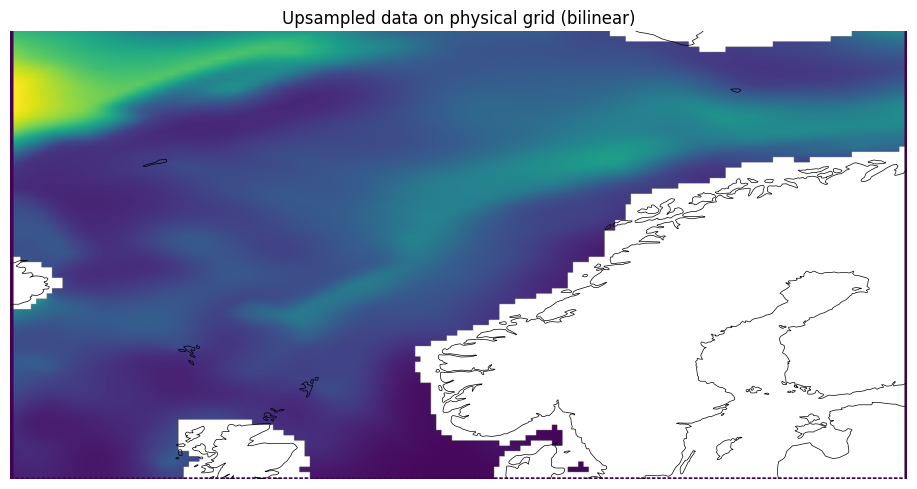

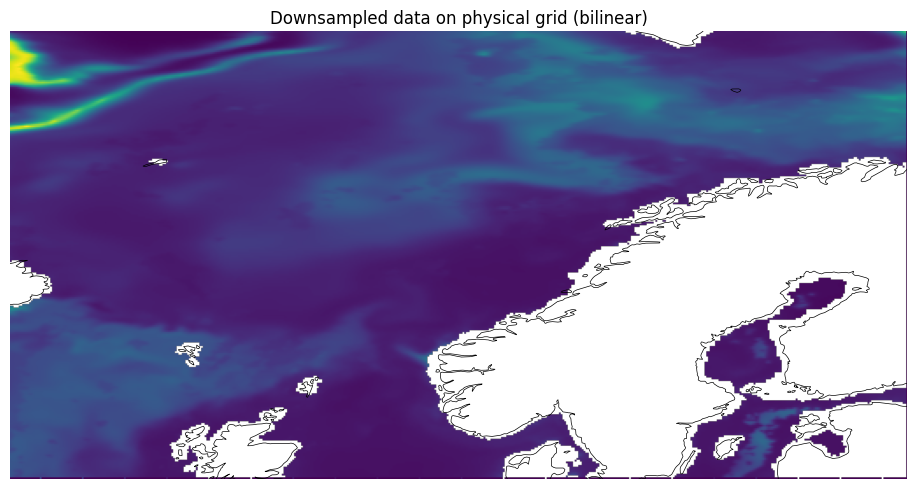

In [8]:
fig, ax = plt.subplots(
	figsize=(10, 5),
	subplot_kw={'projection': cartopy.crs.PlateCarree()}
)

# set extent to match the physical grid
ax.set_extent((lon_min_phy, lon_max_phy, lat_min_phy, lat_max_phy),
			  crs=cartopy.crs.PlateCarree())

# draw coastlines first
ax.coastlines(linewidth=0.5)

# overlay the downsampled image
ax.imshow(
	im_up,
	origin='lower',
	extent=(lon_min_phy, lon_max_phy, lat_min_phy, lat_max_phy),
	# transform=cartopy.crs.PlateCarree(),
	cmap='viridis'
)
ax.set_title(f"Upsampled data on physical grid ({interp_method})")

plt.tight_layout()
# remove black line in axis for clarity
for spine in ax.spines.values():
	spine.set_visible(False)

plt.show()


fig, ax = plt.subplots(
	figsize=(10, 5),
	subplot_kw={'projection': cartopy.crs.PlateCarree()}
)

# set extent to match the physical grid
ax.set_extent((lon_min_phy, lon_max_phy, lat_min_phy, lat_max_phy),
			  crs=cartopy.crs.PlateCarree())

# draw coastlines first
ax.coastlines(linewidth=0.5)

# overlay the downsampled image
ax.imshow(
	im_down,
	origin='lower',
	extent=(lon_min_phy, lon_max_phy, lat_min_phy, lat_max_phy),
	# transform=cartopy.crs.PlateCarree(),
	cmap='viridis'
)

ax.set_title(f"Downsampled data on physical grid ({interp_method})")

plt.tight_layout()
# remove black line in axis for clarity
for spine in ax.spines.values():
	spine.set_visible(False)

plt.show()



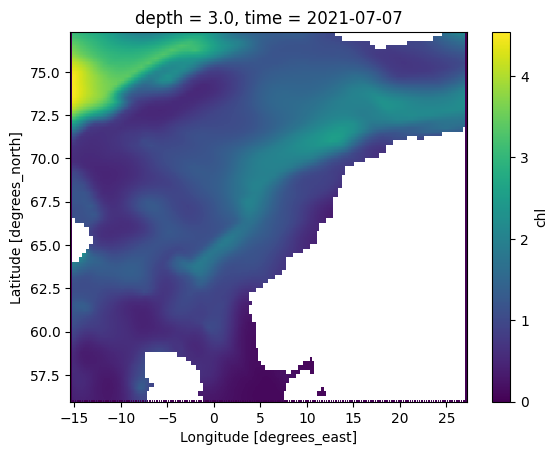

In [9]:
# TODO: find a mask for the nan values in the upsampled  and downsampled data
arr_up_masked = ds_up_on_phy.chl.isel(depth=0, time=0).where(ds_up_on_phy.chl.notnull(), np.nan)
arr_dn_masked = ds_down_on_phy.chl.isel(depth=0, time=0).where(ds_down_on_phy.chl.notnull(), np.nan)
arr_dn_masked.shape
arr_up_masked.plot(
	cmap="viridis")

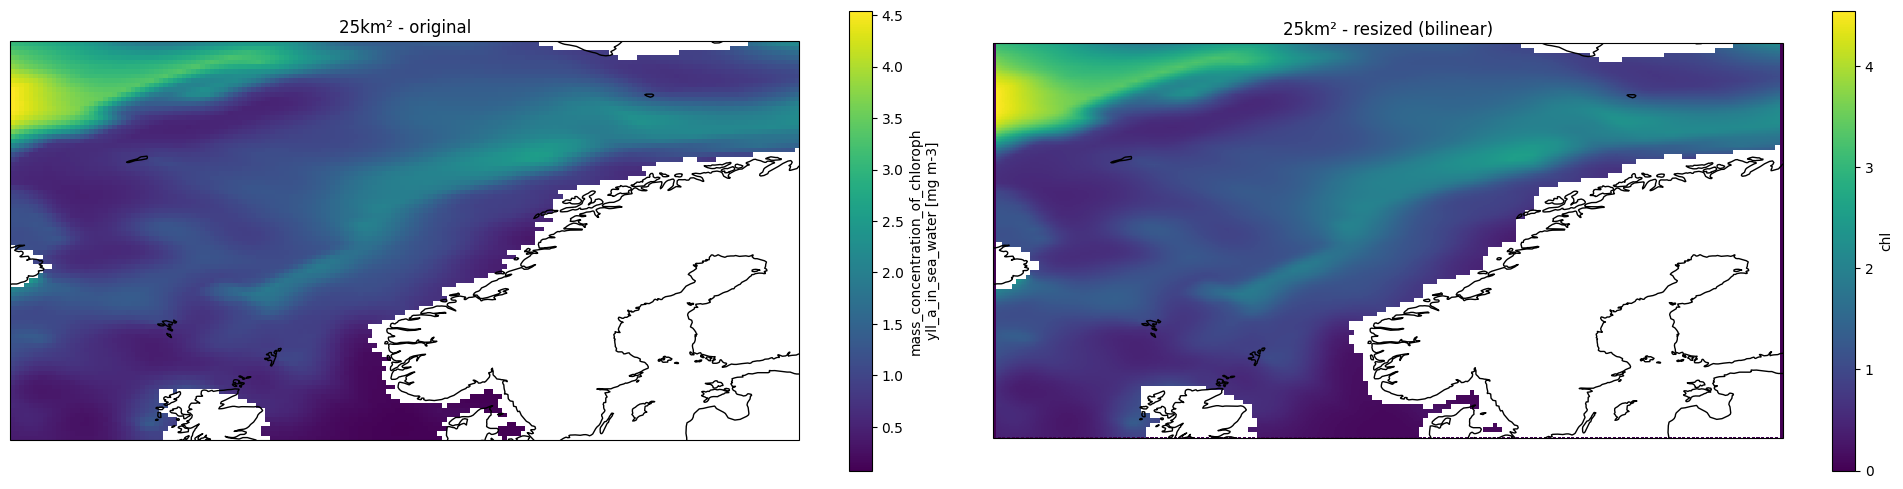

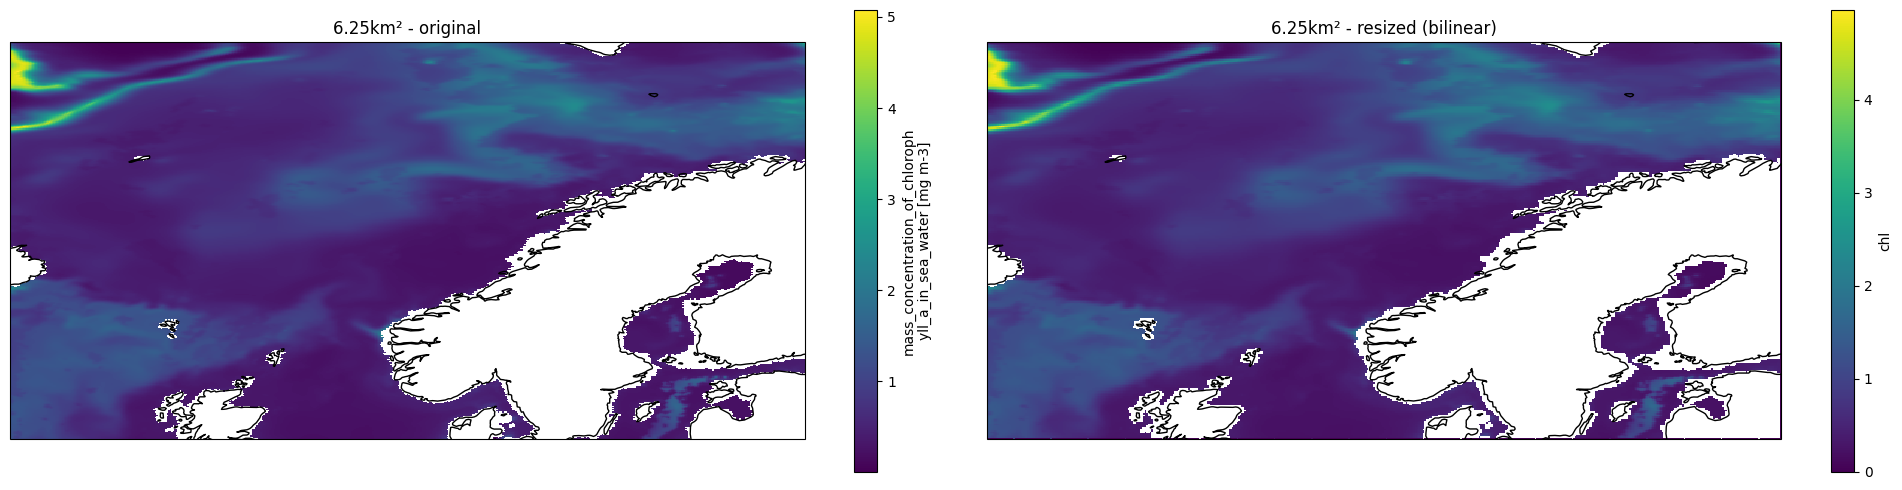

KeyError: 'chl'

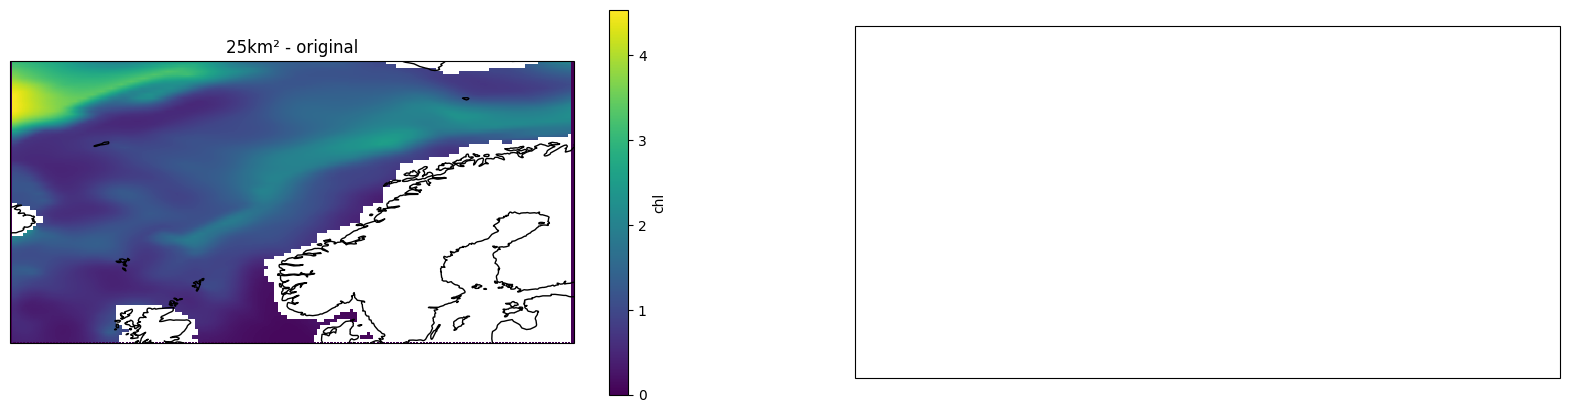

In [10]:
size = (10, 5)  # size of the figure in inches
pairs = [
	("25km²", f"{interp_method}",     ds25,     ds_up_on_phy),
	("6.25km²", f"{interp_method}",   ds625,   ds_down_on_phy),
	("25km²", f"{''}",     ds_up_on_phy,     arr_up_masked),
	("6.25km²", f"{''}",   ds_down_on_phy,   arr_dn_masked),
]

for label, method,  orig_ds, interp_ds in pairs:
	fig, axs = plt.subplots(
		1, 2,
		figsize=(size[0] * 2, size[1]),
		subplot_kw={'projection': cartopy.crs.PlateCarree()}
	)

	# original
	orig_ds['chl'].isel(depth=0, time=0).plot(
		ax=axs[0],
		cmap='viridis',
		transform=cartopy.crs.PlateCarree()
	)
	axs[0].coastlines()
	axs[0].set_title(f"{label} - original")

	# interpolated
	interp_ds['chl'].isel(depth=0, time=0).plot(
		ax=axs[1],
		cmap='viridis',
		transform=cartopy.crs.PlateCarree()
	)
	axs[1].coastlines()
	axs[1].set_title(f"{label} - resized ({method})")

	plt.tight_layout()
	plt.show()

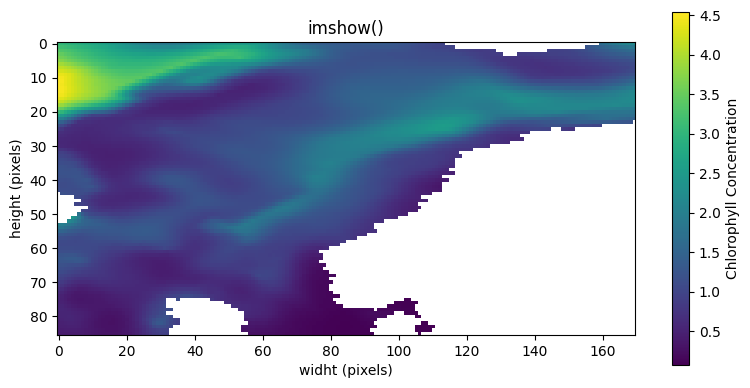

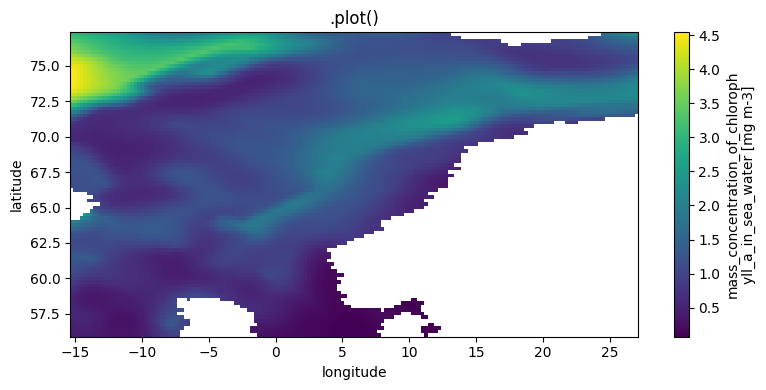

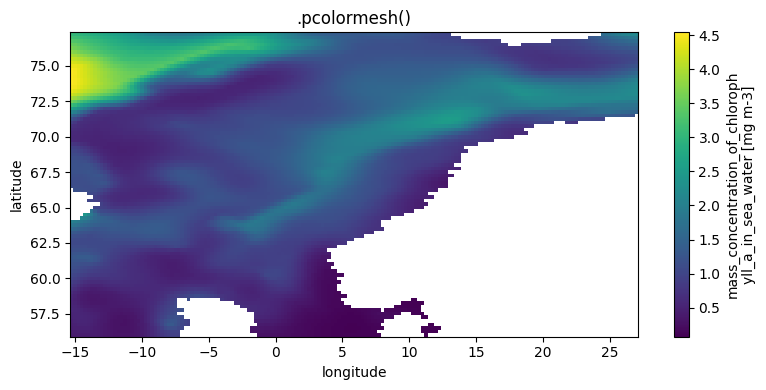

In [ ]:

mat25 = ds25['chl'].isel(depth=0, time=0).values
mat25 = np.flipud(mat25)

mat625 = ds625['chl'].isel(depth=0, time=0).values
mat625 = np.flipud(mat625)

size = (8, 4) 
plt.figure(figsize=size)	
# Using imshow
plt.imshow(mat25, cmap='viridis')
plt.colorbar(label='Chlorophyll Concentration')
plt.xlabel('widht (pixels)')
plt.ylabel('height (pixels)')
plt.title('imshow()')
plt.tight_layout()


plt.figure(figsize=size)	
# using plot
ds25['chl'].isel(depth=0, time=0).plot(cmap='viridis')
plt.title('.plot()')
plt.tight_layout()


plt.figure(figsize=size)	
# using pcolormesh
ds25['chl'].isel(depth=0, time=0).plot.pcolormesh(cmap='viridis')
plt.title('.pcolormesh()')
plt.tight_layout()

In [ ]:
# build the new target coords
new_lat = np.linspace(ds25.latitude.min(), ds25.latitude.max(), 256)
new_lon = np.linspace(ds25.longitude.min(), ds25.longitude.max(), 512)

# methods = { "linear", "nearest", "zero", "slinear", "quadratic", "cubic", "quintic", "polynomial", "pchip", "barycentric", "krogh", "akima", "makima" }

interp_method = 'linear'

# interp the upsampled one
ds25_upsample = ds25.interp(latitude=new_lat, longitude=new_lon, method=interp_method)

# interp the downsampled one to the same grid
ds625_downsample = ds625.interp(latitude=new_lat, longitude=new_lon, method=interp_method)

mat_up = ds25_upsample['chl'].isel(depth=0, time=0).values
mat_dn = ds625_downsample['chl'].isel(depth=0, time=0).values
mat_up = np.flipud(mat_up)
mat_dn = np.flipud(mat_dn)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# original resolution
axs[0].imshow(mat25, cmap='viridis')
axs[0].set_title('Original (25 km)')

# upsampled to 256×512
axs[1].imshow(mat_up, cmap='viridis')
axs[1].set_title('Upsampled ')

plt.tight_layout()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# original resolution
axs[0].imshow(mat625, cmap='viridis')
axs[0].set_title('Original (6.25 km)')

# upsampled to 256×512
axs[1].imshow(mat_dn, cmap='viridis')
axs[1].set_title('Downsampled ')

plt.tight_layout()

ValueError: dimensions () must have the same length as the number of data dimensions, ndim=1

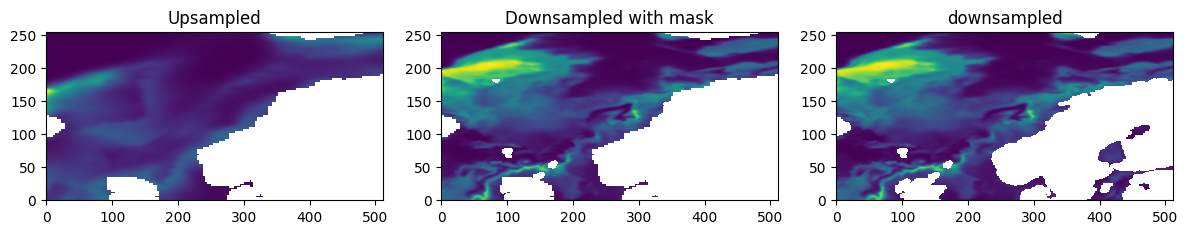

In [ ]:
# choose your variable and depth
var = "chl"
depth = 0.0  # or whatever level you want

# 1) get upsampled data array (drop singleton time dim)
up_da = ds25_upsample[var].sel(depth=depth, method="nearest").isel(time=0)
arr_up = up_da.values       # shape (lat, lon)

# 2) build a mask: True where up is valid
mask = ~np.isnan(arr_up)

# 3) get downsampled data same way
dn_da = ds625_downsample[var].sel(depth=depth, method="nearest").isel(time=0)
arr_dn = dn_da.values       # shape (lat, lon)

# 4) impose mask: wherever up was NaN, set down to NaN
arr_dn_masked = np.where(mask, arr_dn, np.nan)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# original 
axs[0].imshow(arr_up, origin="lower", cmap="viridis")
axs[0].set_title(f"Upsampled")

# imposed mask
axs[1].imshow(arr_dn_masked, origin="lower", cmap="viridis")
axs[1].set_title(f"Downsampled with mask")

# original downsampled
axs[2].imshow(arr_dn, origin="lower", cmap="viridis")
axs[2].set_title(f"downsampled")

plt.tight_layout()

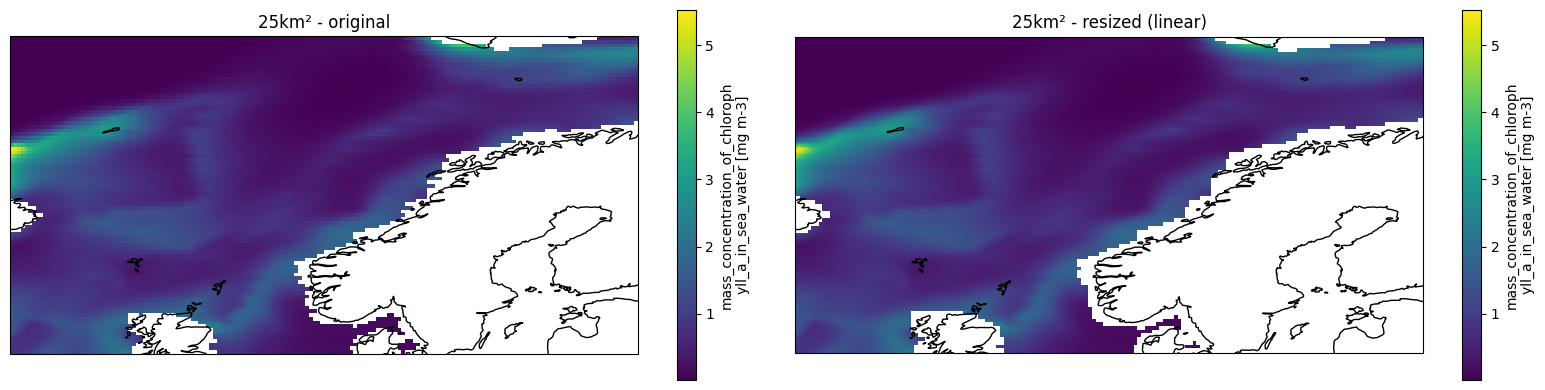

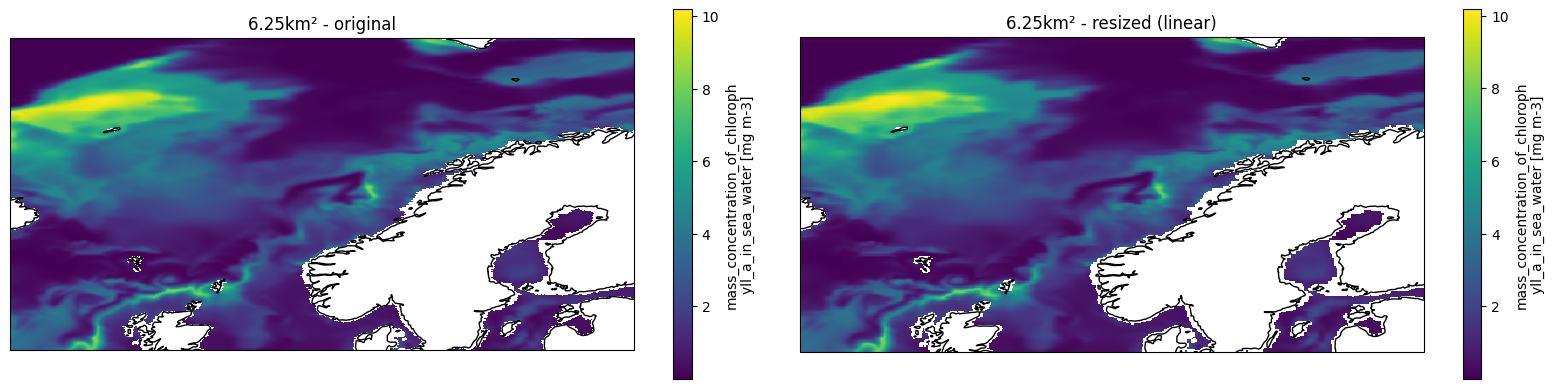

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

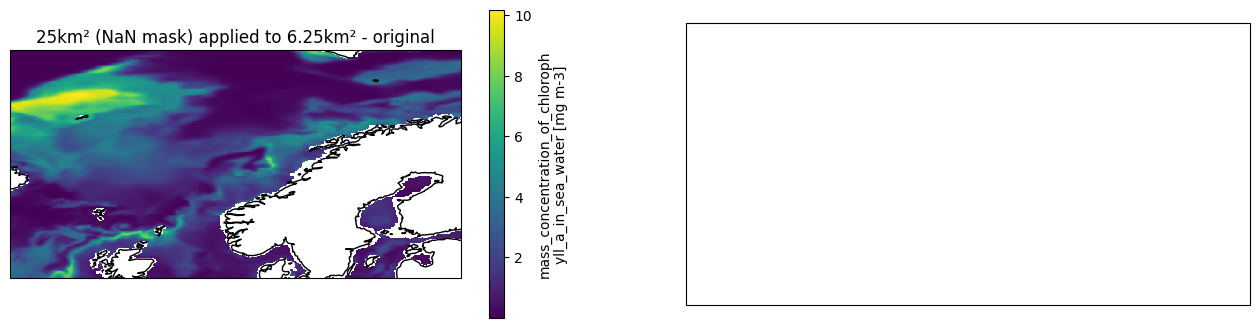

In [ ]:
pairs = [
	("25km²", f"{interp_method}",     ds25,     ds25_upsample),
	("6.25km²", f"{interp_method}",   ds625,   ds625_downsample),
	("25km² (NaN mask) applied to 6.25km²", f"", ds625_downsample, arr_dn_masked),
]

for label, method,  orig_ds, interp_ds in pairs:
	fig, axs = plt.subplots(
		1, 2,
		figsize=(size[0] * 2, size[1]),
		subplot_kw={'projection': cartopy.crs.PlateCarree()}
	)

	# original
	orig_ds['chl'].isel(depth=0, time=0).plot(
		ax=axs[0],
		cmap='viridis',
		transform=cartopy.crs.PlateCarree()
	)
	axs[0].coastlines()
	axs[0].set_title(f"{label} - original")

	# interpolated
	interp_ds['chl'].isel(depth=0, time=0).plot(
		ax=axs[1],
		cmap='viridis',
		transform=cartopy.crs.PlateCarree()
	)
	axs[1].coastlines()
	axs[1].set_title(f"{label} - resized ({method})")

	plt.tight_layout()
	plt.show()